In [1]:
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from torch import nn
from torchvision import transforms, utils
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import pytorch_lightning as pl
import numpy as np
from pycocotools.coco import COCO

from PIL import Image, ImageDraw
import cv2 as cv
import os
import requests
from io import BytesIO
from IPython.display import Video

In [2]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [3]:
def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predicotr = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    
    return model

In [4]:
class WaifuDataset(object):
    def __init__(self, root, annotation, transform=None):
        self.root = root
        self.transform = transform
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        img = self.load_img(idx)
        width , height = img.size()[1:]
        target = self.load_annotations(idx, width, height)
        return img, target
    
    def load_annotations(self, idx, width, height):
        coco = self.coco
        img_id = self.ids[idx]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)
        
        mask = np.zeros((width, height))
        for a in coco_annotation:
            mask += (coco.annToMask(a) * a['category_id'])
        
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:] # first ID is background --> remove it        
        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3] 
            boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        img_id = torch.tensor([img_id])
        
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
            
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        target["area"] = areas
        target["iscrowd"] = iscrowd
        target["masks"] = masks
    
        return target
    
    
    def load_img(self, idx):
        img_id = self.ids[idx]
        image_name = self.coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, image_name)).convert('RGB')
        img = transforms.ToTensor()(img)
        if self.transform is not None:
            img = self.transform(img)
        return img
        

In [5]:
image_path = "./data/waifus/images"
annot_path = "./data/waifus/trainval.json"
dataset = WaifuDataset(image_path, annot_path)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [6]:
train_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn)

In [7]:
class WaifuSegmentationModel(pl.LightningModule):
    def __init__(self, num_classes=2):
        super().__init__()
        self.model = get_instance_segmentation_model(num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def configure_optimizers(self):
        opt = torch.optim.SGD(self.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.1)
        return [opt], [scheduler]

    def training_step(self, batch, batch_idx):
        images, targets = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        loss_dict = self.model(images, targets)
        loss = sum(l for l in loss_dict.values())
        return {'loss': loss, 'log': loss_dict}

In [8]:
model = WaifuSegmentationModel()

In [9]:
trainer = pl.Trainer(gpus=1, max_epochs=15)
trainer.fit(model, train_loader)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

    | Name                                           | Type                     | Params
----------------------------------------------------------------------------------------
0   | model                                          | MaskRCNN                 | 44 M  
1   | model.transform                                | GeneralizedRCNNTransform | 0     
2   | model.backbone                                 | BackboneWithFPN          | 26 M  
3   | model.backbone.body                            | IntermediateLayerGetter  | 23 M  
4   | model.backbone.body.conv1                      | Conv2d                   | 9 K   
5   | model.backbone.body.bn1                        | FrozenBatchNorm2d        | 0     
6   | model.backbone.body.relu                       | ReLU                     | 0     
7   | model.backbone.body.maxpool                    | MaxPool2d                | 0

c:\users\thien\.virtualenvs\i2dl-a4dtsivt\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
c:\users\thien\.virtualenvs\i2dl-a4dtsivt\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.

1

In [10]:
def get_prediction(image, model):
    img = transforms.ToTensor()(image)
    model.eval()
    with torch.no_grad():
        pred = model([img.cuda()])

    masks = pred[0]['masks'].cpu()
    mask = torch.zeros(masks.size()[1:])
    for m in masks:
        mask = torch.max(mask, m)

    mask = (mask[0] >= 0.5).float()
    mask_img = Image.fromarray(mask.mul(255).byte().numpy())
    return mask_img

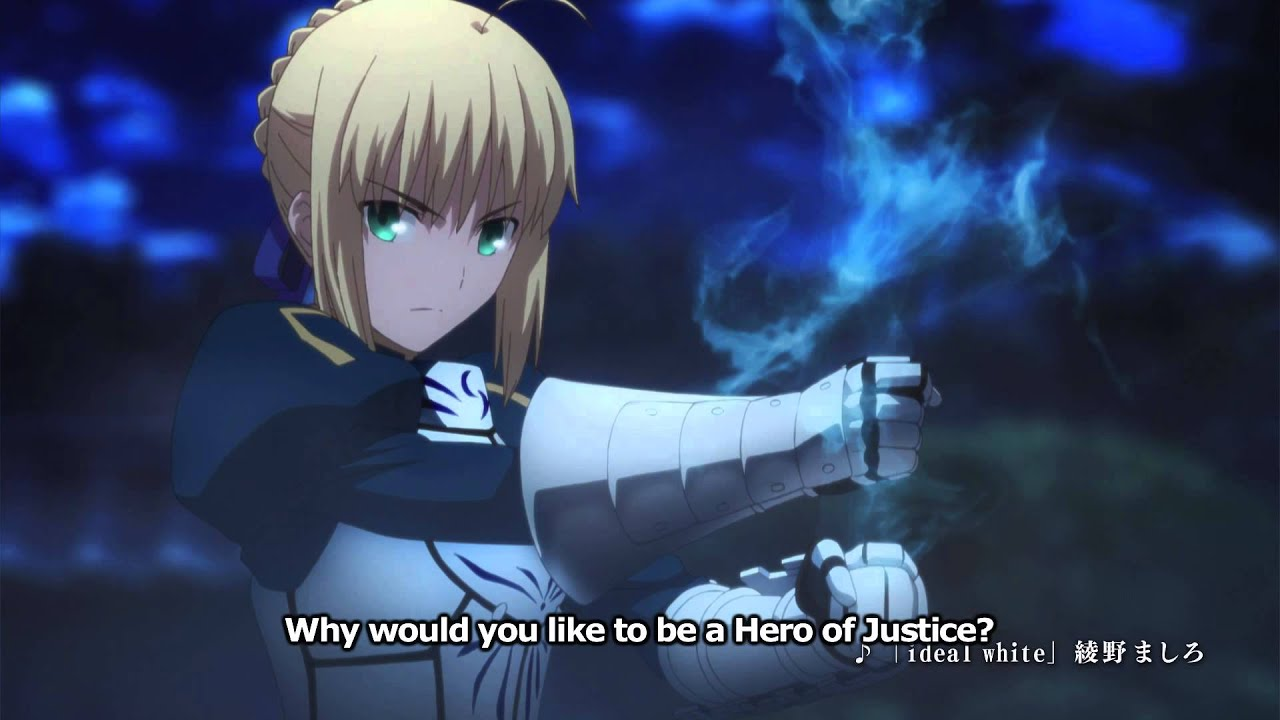

In [11]:
response = requests.get("https://i.ytimg.com/vi/gHooJLcpmY8/maxresdefault.jpg")
img = Image.open(BytesIO(response.content))
img

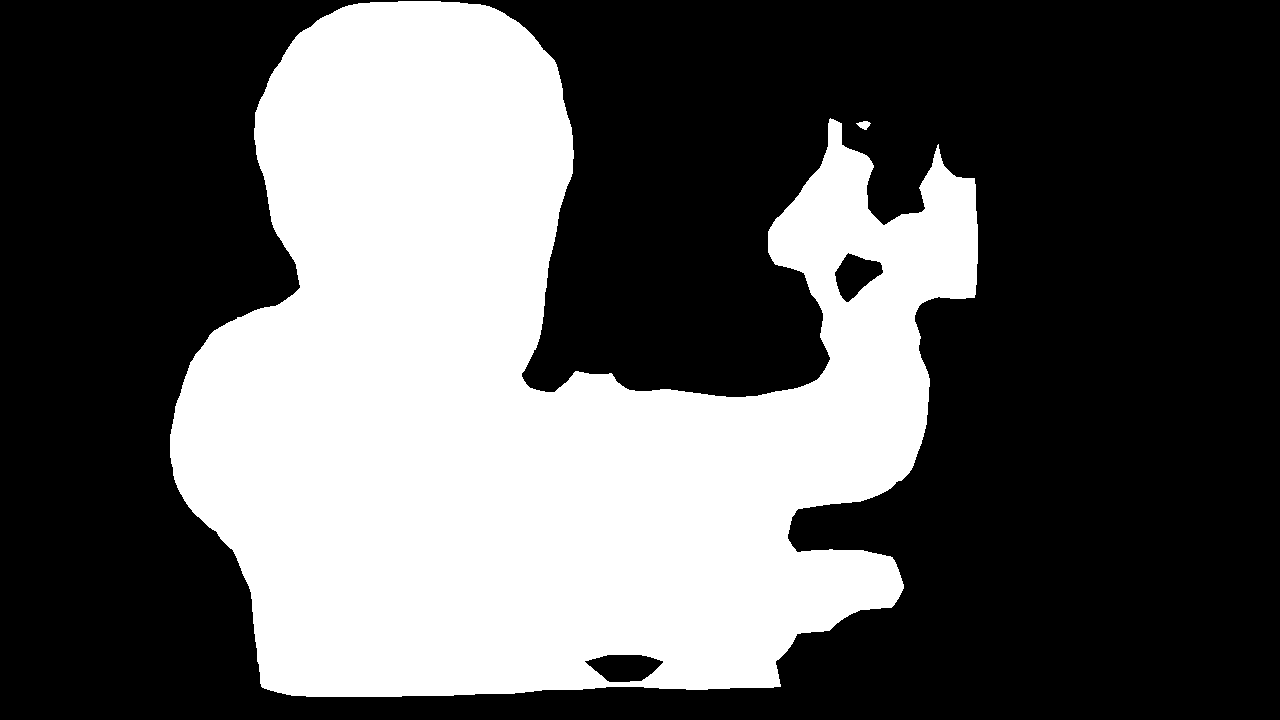

In [12]:
mask = get_prediction(img, model)
mask

In [13]:
def show_instance_segmentation(image, model):
    mask = get_prediction(image, model)
    img_rgba = image.convert('RGBA')
    
    overlay = Image.new('RGBA', img_rgba.size, (255, 255, 255, 0))
    drawing = ImageDraw.Draw(overlay)
    drawing.bitmap((0, 0), mask, fill=(255, 0, 0, 128))
    
    output = Image.alpha_composite(img_rgba, overlay)
    return output

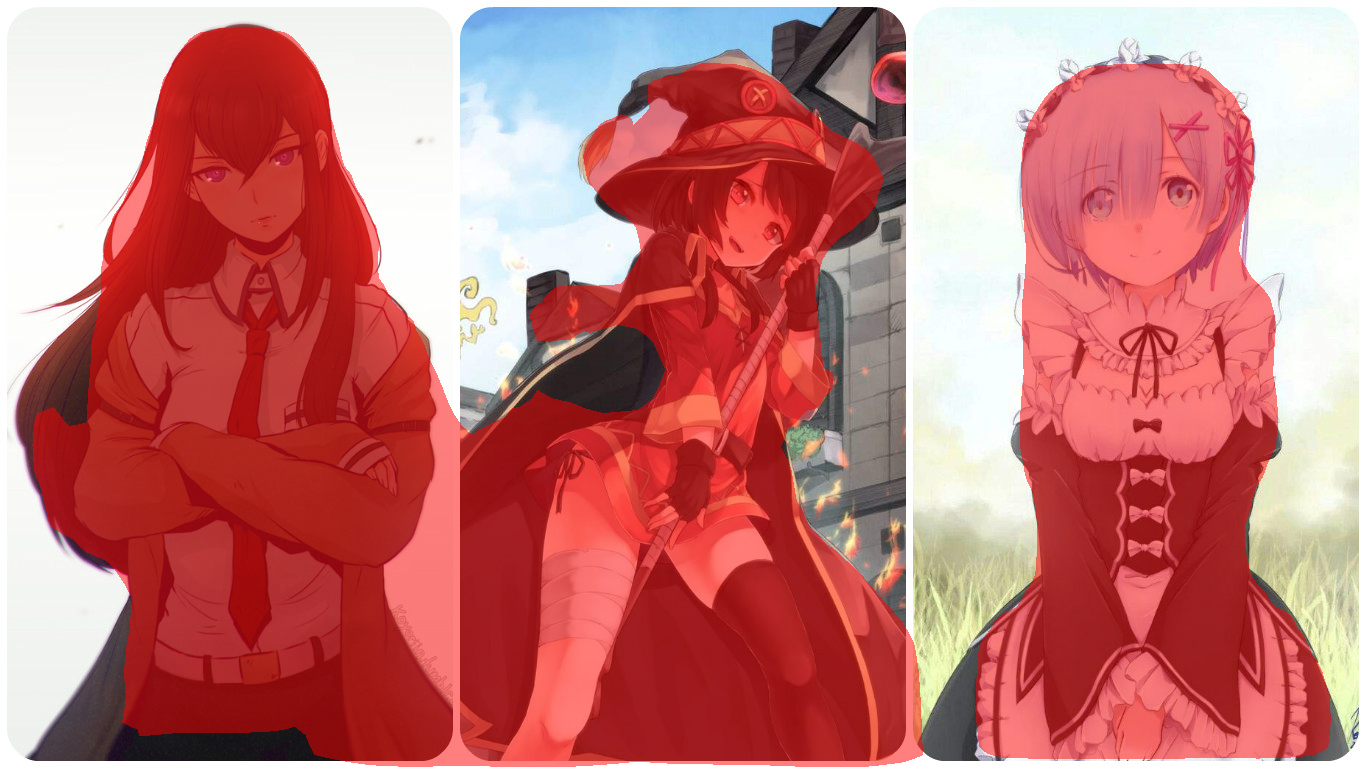

In [14]:
response = requests.get("https://img.anime2you.de/2017/03/header.jpg")
img = Image.open(BytesIO(response.content))
show_instance_segmentation(img, model)

In [16]:
Video('saiba_volleyball.mp4', width=512, height=288)

In [17]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [22]:
from cv2 import VideoWriter_fourcc
def generate_video(frames, name):
    frame_folder = './frames/'
    images = [img for img in os.listdir(frame_folder) if img.endswith(".jpg") or img.endswith(".png") or img.endswith(".jpeg")]
    images = sorted_alphanumeric(images)
    video = cv.VideoWriter(name, VideoWriter_fourcc(*'MP4V'), 30, frames[0].size)
    for image in images:
        video.write(cv.imread(os.path.join(frame_folder, image)))  
        
    cv.destroyAllWindows()
    video.release()

In [23]:
cap = cv.VideoCapture('saiba_volleyball.mp4')
frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting...")
        break
    
    input_img = Image.fromarray(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
    seg_frame = show_instance_segmentation(input_img, model)
    frames.append(seg_frame)
    cv.imshow('frame', frame)
    if cv.waitKey(1) == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

Can't receive frame (stream end?). Exiting...


In [24]:
for i, frame in enumerate(frames):
    path = './frames/frame_' + str(i) + '.jpg'
    frame.convert('RGB').save(path)

In [25]:
generate_video(frames, "video_with_predictions.mp4")

In [30]:
from moviepy.editor import *
video = VideoFileClip('saiba_volleyball.mp4')
audio = video.audio
out_video = VideoFileClip("video_with_predictions.mp4")
out_video.audio = audio
out_video.write_videofile('segmentation_video.mp4')

chunk:   3%|█▌                                                            | 37/1444 [00:00<00:03, 366.55it/s, now=None]

Moviepy - Building video segmentation_video.mp4.
MoviePy - Writing audio in segmentation_videoTEMP_MPY_wvf_snd.mp3


t:   0%|▏                                                                   | 5/1962 [00:00<00:42, 45.90it/s, now=None]

MoviePy - Done.
Moviepy - Writing video segmentation_video.mp4



Moviepy - Done !
Moviepy - video ready segmentation_video.mp4


In [31]:
Video('segmentation_video.mp4', width=512, height=288)

In [32]:
torch.save(model.state_dict(), './waifu_detector.pth')